<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_18/s18_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo


Cloning into 'ERA_V1'...
remote: Enumerating objects: 1497, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 1497 (delta 31), reused 34 (delta 5), pack-reused 1407
Receiving objects: 100% (1497/1497), 201.92 MiB | 26.57 MiB/s, done.
Resolving deltas: 100% (723/723), done.
fatal: not a git repository (or any of the parent directories): .git


In [2]:
import sys
sys.path.append("ERA_V1/session_18")


Add all the imports:

In [53]:
from __future__ import print_function
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from unet_model import UNet
from data_loader import load_oxford_pet_data

Allocate GPU and print model summary

In [54]:
def model_summary(model, input_size):
    summary(model, input_size = input_size)

In [57]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
unet_model = UNet(in_channels=3,out_channels=1).to(device)
model_summary(unet_model, input_size=(3,48,48))


RuntimeError: ignored

Define Albumentations image augmentations. We use RandomResizedCrop, HorizontalFlip, and cutout

In [29]:
train_transforms = transforms.Compose(
    [
        transforms.Resize(48),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose([
    transforms.Resize(48),
    transforms.ToTensor(),
])
target_transform = transforms.Compose([transforms.Resize(48)])

In [42]:
import numpy as np
from typing import Any
from torchvision import datasets, transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

def oxford_transforms(image, mask):
    # Resize
    resize = transforms.Resize(size=(48, 48))
    image = resize(image)
    mask = resize(mask)

    # Transform to tensor
    to_tensor = transforms.ToTensor()
    image = to_tensor(image)
    mask = to_tensor(mask)
    return image, mask

class OxfordPetDataset(Dataset):

    def __init__(self, dataset, transforms=None):
        self.transforms = transforms
        self.dataset = dataset


    def __len__(self) -> int:
        return len(self.dataset)


    def __getitem__(self, index) -> Any:
        image, label = self.dataset[index]
        image = np.array(image)
        if self.transforms is not None:
            image = self.transforms(image)
        return (image, label)


def load_oxford_pet_data(train_transforms, test_transforms, batch_size, **kwargs):
    train_data = datasets.OxfordIIITPet('../data', split='trainval', transforms = train_transforms, target_transform = None, target_types='segmentation', download=True)
    test_data = datasets.OxfordIIITPet('../data', split='test', transforms = test_transforms, target_transform = None, target_types='segmentation', download=True)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              **kwargs)
    test_loader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True,
                             **kwargs)
    return train_loader, test_loader




Define batch size, train and test loaders

In [43]:
torch.manual_seed(1)
batch_size = 32
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader = load_oxford_pet_data(train_transforms=oxford_transforms, test_transforms=oxford_transforms, batch_size=batch_size, **kwargs)

In [45]:
a,b = next(iter(train_loader))


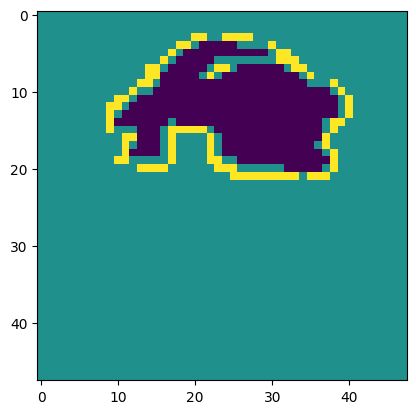

In [52]:
c = np.asarray(b[0])
import matplotlib.pyplot as plt
plt.imshow(c.squeeze())
plt.show()

Preview Augmentations

Show sample Images from the dataset

In [ ]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

In [ ]:
drop_out = 0.02
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10,drop_out_probability=drop_out).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optim_obj = Optimization(resnet_model, device, train_loader, criterion, num_epochs)
lr_history = find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []
max_lr = 4.65e-2
# Define scheduler
optim_obj.define_scheduler(max_lr)

for epoch in range(1,num_epochs+1):
    lr_values.append(optim_obj.scheduler.get_lr())
    print(f"epoch: {epoch}\t learning rate: {optim_obj.scheduler.get_last_lr()[0]}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, optim_obj.scheduler, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()



Plot LR values

In [ ]:
import matplotlib.pyplot as plt
def plot_lr_values2(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    #plt.yscale('log')
    plt.show()

def plot_lr_values(scheduler, num_epochs, num_batches):
    lrs = []
    steps = []
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            scheduler.step()
            lrs.append(scheduler.get_last_lr()[0])
            steps.append(epoch * num_batches + batch)

    plt.figure()
    plt.legend()
    plt.plot(steps, lrs, label='OneCycle')
    plt.show()

def plot_losses(train_losses, test_losses):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    epochs = range(1,len(train_losses)+1)
    axs[0].plot(epochs, train_losses)
    axs[0].set_title("Train")
    axs[1].plot(epochs, test_losses)
    axs[1].set_title("Test")

def plot_accuracy(train_acc, test_acc, target_test_acc = 90.):
    epochs = range(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epochs, train_acc, epochs, test_acc)
    plt.axhline(target_test_acc, color='r')
    plt.legend(('Train','Test'),loc='best')
    plt.title("Accuracy")


Plot results for Batch Norm experiment

In [ ]:
this_scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=200,
        three_phase=False,
        #final_div_factor=1000,
        anneal_strategy='linear',
        verbose=False
        )
plot_lr_values(this_scheduler, num_epochs, len(train_loader))
plot_losses(train_losses, test_losses)
plot_accuracy(train_acc, test_acc, target_test_acc=90.)


Print Training Log

In [ ]:
print_train_log(train_acc, test_acc, train_losses, test_losses)